In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats
from numpy import mean
#import pprint

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
Measurement_columns = inspector.get_columns('Measurement')
Station_columns = inspector.get_columns('Station')
for c in Measurement_columns:
    print(c['name'], c["type"])
for c in Station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_day)
last_day_last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_day_last_year)

('2017-08-23',)
2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
One_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).all() 

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
One_year_prcp_df = pd.DataFrame(One_year_prcp, columns=['date', 'prcp'])
One_year_prcp_df.sort_values('date', inplace=True, ascending=True)
One_year_prcp_df.set_index('date', inplace=True)
One_year_prcp_df.dtypes
One_year_prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


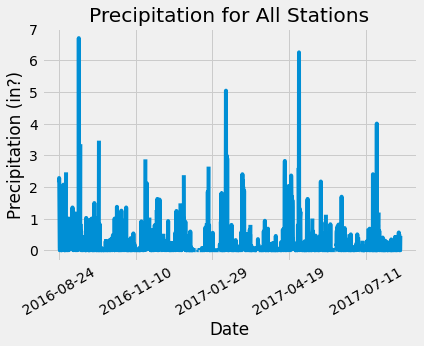

<Figure size 432x288 with 0 Axes>

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
#This plot doesn't really make sense (mixed stations), but seems to be what's asked for.
ax = One_year_prcp_df.plot(title="Precipitation for All Stations", rot=30, legend=False)
ax.set_ylabel("Precipitation (in?)")
ax.set_xlabel("Date")
plt.show()
plt.savefig("Precipitation_all_stations.png")

###Assorted questions

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
One_year_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(stations)

#Double check:
#stations = session.query(Station.station).all()
#print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity =  session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).\
    all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#Checking that maximum activity is at the same station for different observations
station_temp_activity =  session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    all()
station_temp_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Checking that maximum activity is at the same station for different observations
station_prcp_activity =  session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).\
    all()
station_prcp_activity

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Thanks to Monica T. James of the internet for a quicker way of doing this! I think I will delete my ugly method.
busiest_station = station_prcp_activity[0][0]
busiest_station
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
              func.max(Measurement.tobs)).filter(Measurement.station == busiest_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [21]:
busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_tobs

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_tobs
busiest_station_tobs_df = pd.DataFrame(busiest_station_tobs, columns=['date', 'tobs'])
busiest_station_tobs_df.sort_values('date', inplace=True, ascending=True)
busiest_station_tobs_df.set_index('date', inplace=True)
busiest_station_tobs_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


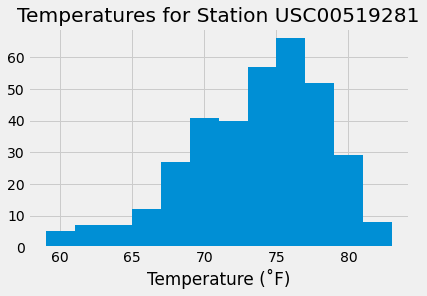

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the results as a histogram
busiest_station_tobs_df.hist(bins=12)
plt.tight_layout()
plt.title(f"Temperatures for Station {busiest_station}")
plt.xlabel("Temperature (˚F)")
plt.show()
plt.savefig("Busiest_station_temps.png")

In [24]:
# Using the the station with the highest number of temperature (and prcp) observations:
# Query the last 12 months of prcp observation data for this station
busiest_station_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_prcp_df = pd.DataFrame(busiest_station_prcp, columns=['date', 'prcp'])
busiest_station_prcp_df.sort_values('date', inplace=True, ascending=True)
busiest_station_prcp_df.set_index('date', inplace=True)
busiest_station_prcp_df.dtypes
busiest_station_prcp_df

,prcp
date,
2016-08-24,2.15
2016-08-25,0.06
2016-08-26,0.01
2016-08-27,0.12
2016-08-28,0.60
...,...
2017-08-14,0.00
2017-08-15,0.32
2017-08-16,0.12


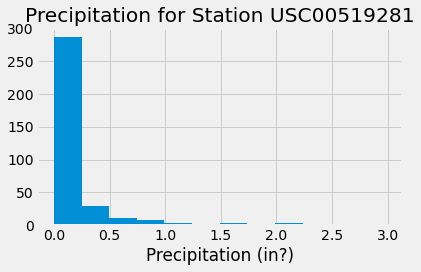

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the results as a histogram, just because
busiest_station_prcp_df.hist(bins=12)
plt.title(f"Precipitation for Station {busiest_station}")
plt.xlabel("Precipitation (in?)")
plt.tight_layout()
plt.show()
plt.savefig("Busiest_station_prcp.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
